# Considerations of vehicle specific behaviors

In [2]:
import os
import sys
import math
sys.path.append(os.path.join(os.getcwd().partition('nature_soh')[0], "nature_soh"))
from src.config_base import GeneralConfig

In [3]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import matplotlib.gridspec as gridspec
from matplotlib.ticker import AutoMinorLocator, FixedLocator
import matplotlib.patches as patches
import matplotlib.patheffects as mpe

In [4]:
from src.data.read_feather import ReadFeather
from src.filtering.filter_methods import FilterMethods
from src.voltage_capacity_analysis.dva import DVA
from src.visualization.config_visualization import VisualizationConfig, instantiate_matplotlib_parameters, cm2inch
instantiate_matplotlib_parameters()
from src.visualization.colormaps import ColorMaps

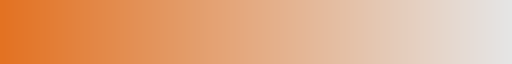

In [5]:
tum_orange_cmap = ColorMaps.orange_tum()
orange_colors = tum_orange_cmap(np.linspace(0,1, 10))
tum_orange_cmap

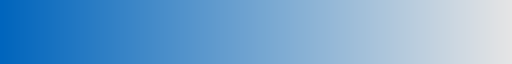

In [6]:
tum_blue_cmap = ColorMaps.blue_tum()
blue_colors = tum_blue_cmap(np.linspace(0,1, 10))
tum_blue_cmap

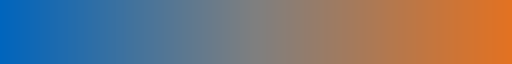

In [7]:
tum_cmap = ColorMaps.blue_orange_tum(grayscale=0.5)
colors = tum_cmap(np.linspace(0,1, 5))
tum_cmap

## Load Data

In [9]:
def filter_func_preprocess(signal):
    perc_filter = 1/100 * len(signal) #% filter
    filtered_signal = FilterMethods().rolling_mean_df(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter))
    #filtered_signal = FilterMethods().savgol(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter * len(signal)))
    return filtered_signal

In [10]:
read_feather = ReadFeather()
read_feather.set_filter_U(filter_func_preprocess)
read_feather.set_filter_Q(filter_func_preprocess)

In [11]:
df_taycan =  read_feather.read(os.path.join(GeneralConfig.path2data.value,"Taycan","Porsche_Taycan_JB_10A_CEE7_AMS.feather"))

In [12]:
df_vw =  read_feather.read(os.path.join(GeneralConfig.path2data.value,"VW","VW_ID3_JB_8A_C40_2021.feather"))

In [13]:
df_vw_2 =  read_feather.read(os.path.join(GeneralConfig.path2data.value,"VW","VW_ID3_JB_8A_C40_2023.feather"))

In [14]:
df_vw_3 =  read_feather.read(os.path.join(GeneralConfig.path2data.value,"VW","VW_ID3_JB_8A_C40_2024.feather"))

In [15]:
%%capture
df_vw["E"] = sp.integrate.cumtrapz((df_vw["U"].values*df_vw["I"].values)/1000, df_vw["time_h"], initial=0)
df_vw_2["E"] = sp.integrate.cumtrapz((df_vw_2["U"].values*df_vw_2["I"].values)/1000, df_vw_2["time_h"], initial=0)
df_vw_3["E"] = sp.integrate.cumtrapz((df_vw_3["U"].values*df_vw_3["I"].values)/1000, df_vw_3["time_h"], initial=0)

In [16]:
df_vw_relax =  read_feather.read(os.path.join(GeneralConfig.path2data.value,"VW","VW_ID3_FTM_8A_CEE7_postAnode_Relaxation.feather"))

In [17]:
df_vw_balance2 =  read_feather.read(os.path.join(GeneralConfig.path2data.value,"VW","VW_ID3_FTM_JB_8A_CEE7_2023_w_balancing.feather"))

In [18]:
df_vw_balance =  read_feather.read(os.path.join(GeneralConfig.path2data.value,"VW","VW_ID3_FTM_8A_CEE7_preAnode_Balancing.feather"))

In [19]:
df_vw_cell_defect = read_feather.read(os.path.join(GeneralConfig.path2data.value,"VW","VW_ID3_GB_JB_8A_CEE7_cell_defect.feather"))

In [20]:
df_tesla =  read_feather.read(os.path.join(GeneralConfig.path2data.value,"Tesla","Tesla_JB_6A_CEE7_C57_2022.feather"))

In [21]:
df_polestar =  read_feather.read(os.path.join(GeneralConfig.path2data.value,"Polestar_2","Polestar_2_JB_10A_CEE7.feather"))

In [22]:
df_cupra_288 =  read_feather.read(os.path.join(GeneralConfig.path2data.value,"Cupra","2024","Cupra_288_JB_8A_CEE7.feather"))

In [23]:
df_cupra_397 =  read_feather.read(os.path.join(GeneralConfig.path2data.value,"Cupra","2024","Cupra_397_JB_8A_CEE7.feather"))

In [24]:
df_cupra_349 =  read_feather.read(os.path.join(GeneralConfig.path2data.value,"Cupra","2024","Cupra_349_JB_8A_CEE7.feather"))

In [25]:
df_cupra_204 =  read_feather.read(os.path.join(GeneralConfig.path2data.value,"Cupra","2024","Cupra_204_JB_8A_CEE7.feather"))

In [26]:
df_cupra_213 =  read_feather.read(os.path.join(GeneralConfig.path2data.value,"Cupra","2024","Cupra_213_JB_8A_CEE7.feather"))

In [28]:
df_cupra_213_rep1 = read_feather.read(os.path.join(GeneralConfig.path2data.value,"Cupra","2022","Cupra_213_JB_8A_CEE7_C45.feather"))

In [29]:
df_cupra_213_rep2 = read_feather.read(os.path.join(GeneralConfig.path2data.value,"Cupra","2022","Cupra_213_JB_8A_CEE7_C45_repeatability.feather"))

In [30]:
df_cupra_213_rep3 = read_feather.read(os.path.join(GeneralConfig.path2data.value,"Cupra","2022","Cupra_213_JB_8A_CEE7_C45_repeatability_2.feather"))

In [31]:
%%capture
df_cupra_213_rep1["SOC_Q"] = df_cupra_213_rep1["Q"].values/df_cupra_213_rep1["Q"].max()*100
df_cupra_213_rep2["SOC_Q"] = df_cupra_213_rep2["Q"].values/df_cupra_213_rep2["Q"].max()*100
df_cupra_213_rep3["SOC_Q"] = df_cupra_213_rep3["Q"].values/df_cupra_213_rep3["Q"].max()*100

In [32]:
df_cupra_288_C45 = read_feather.read(os.path.join(GeneralConfig.path2data.value,"Cupra","2022","Cupra_288_JB_8A_CEE7_C45.feather"))
np.mean(df_cupra_288_C45["U"]*df_cupra_288_C45["I"])

1439.042932501062

In [33]:
df_cupra_288_C17 = read_feather.read(os.path.join(GeneralConfig.path2data.value,"Cupra","2022","Cupra_288_JB_6A_CEE16_C17.feather"))
np.mean(df_cupra_288_C17["U"]*df_cupra_288_C17["I"])

3742.6386490538375

In [34]:
df_cupra_288_C10 = read_feather.read(os.path.join(GeneralConfig.path2data.value,"Cupra","2022","Cupra_288_JB_10A_CEE16_C10.feather"))
np.mean(df_cupra_288_C10["U"]*df_cupra_288_C10["I"])

6104.108513925527

In [35]:
df_cupra_288_C6 = read_feather.read(os.path.join(GeneralConfig.path2data.value,"Cupra","2022","Cupra_288_JB_32A_CEE32_C6.feather"))
np.mean(df_cupra_288_C6["U"]*df_cupra_288_C6["I"])

10376.598007986517

In [36]:
%%capture
df_cupra_288_C45["E"] = sp.integrate.cumtrapz((df_cupra_288_C45["U"].values*df_cupra_288_C45["I"].values)/1000, df_cupra_288_C45["time_h"], initial=0)
df_cupra_288_C17["E"] = sp.integrate.cumtrapz((df_cupra_288_C17["U"].values*df_cupra_288_C17["I"].values)/1000, df_cupra_288_C17["time_h"], initial=0)
df_cupra_288_C10["E"] = sp.integrate.cumtrapz((df_cupra_288_C10["U"].values*df_cupra_288_C10["I"].values)/1000, df_cupra_288_C10["time_h"], initial=0)
df_cupra_288_C6["E"] = sp.integrate.cumtrapz((df_cupra_288_C6["U"].values*df_cupra_288_C6["I"].values)/1000, df_cupra_288_C6["time_h"], initial=0)

In [37]:
8*230

1840

In [38]:
6*400*np.sqrt(3)

4156.921938165306

In [39]:
10*400*np.sqrt(3)

6928.203230275509

In [40]:
16*400*np.sqrt(3)

11085.125168440814

## Cupra voltage spread

In [42]:
%%capture
df_cupra_397["E"] = sp.integrate.cumtrapz((df_cupra_397["U"].values*df_cupra_397["I"].values)/1000, df_cupra_397["time_h"], initial=0)
df_cupra_349["E"] = sp.integrate.cumtrapz((df_cupra_349["U"].values*df_cupra_349["I"].values)/1000, df_cupra_349["time_h"], initial=0)
df_cupra_288["E"] = sp.integrate.cumtrapz((df_cupra_288["U"].values*df_cupra_288["I"].values)/1000, df_cupra_288["time_h"], initial=0)
df_cupra_204["E"] = sp.integrate.cumtrapz((df_cupra_204["U"].values*df_cupra_204["I"].values)/1000, df_cupra_204["time_h"], initial=0)
df_cupra_213["E"] = sp.integrate.cumtrapz((df_cupra_213["U"].values*df_cupra_213["I"].values)/1000, df_cupra_213["time_h"], initial=0)

In [43]:
%%capture
df_cupra_397["SOC_Q"] = df_cupra_397["Q"].values/df_cupra_397["Q"].max()*100
df_cupra_349["SOC_Q"] = df_cupra_349["Q"].values/df_cupra_349["Q"].max()*100
df_cupra_288["SOC_Q"] = df_cupra_288["Q"].values/df_cupra_288["Q"].max()*100
df_cupra_204["SOC_Q"] = df_cupra_204["Q"].values/df_cupra_204["Q"].max()*100
df_cupra_213["SOC_Q"] = df_cupra_213["Q"].values/df_cupra_213["Q"].max()*100

In [44]:
df_U_spread = df_cupra_397[["SOC","SOC_Q","U"]].copy()
df_U_spread = pd.merge_asof(df_U_spread, df_cupra_349[["SOC_Q","U"]].copy(), on=['SOC_Q'], direction='nearest',suffixes=('_397', '_349'))
df_U_spread = pd.merge_asof(df_U_spread, df_cupra_288[["SOC_Q","U"]].copy(), on=['SOC_Q'], direction='nearest',suffixes=('', '_288'))
df_U_spread = pd.merge_asof(df_U_spread, df_cupra_204[["SOC_Q","U"]].copy(), on=['SOC_Q'], direction='nearest',suffixes=('', '_204'))
df_U_spread = pd.merge_asof(df_U_spread, df_cupra_213[["SOC_Q","U"]].copy(), on=['SOC_Q'], direction='nearest',suffixes=('', '_213'))
df_U_spread.rename(columns={"U":"U_288"},inplace=True)

In [45]:
df_U_spread["U_mean"] = df_U_spread[["U_204","U_213","U_288","U_397","U_349"]].mean(axis=1)
df_U_spread["U_min"] = df_U_spread[["U_204","U_213","U_288","U_397","U_349"]].min(axis=1)
df_U_spread["U_max"] = df_U_spread[["U_204","U_213","U_288","U_397","U_349"]].max(axis=1)
df_U_spread["dU_min"] = df_U_spread["U_min"]-df_U_spread["U_mean"]
df_U_spread["dU_max"] = df_U_spread["U_max"]-df_U_spread["U_mean"]

### Tesla Cell DVA

In [47]:
def filter_func_v(signal):
    perc_filter = 1 #% filter
    filtered_signal = FilterMethods().rolling_mean_numpy(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    filtered_signal_reverse = FilterMethods().rolling_mean_numpy(np.flip(signal),window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return (filtered_signal+np.flip(filtered_signal_reverse))/2

In [48]:
dva_extractor = DVA()
dva_extractor.set_filter(filter_func_v)

In [49]:
dva_tesla, soc_tesla =dva_extractor.get_dva(time=df_tesla["time_h"], capacity=df_tesla["Q"], voltage=df_tesla["U"],crop_cap_Ah=(1,180),return_soc = True,soc_signal=df_tesla["SOC"])

In [50]:
df_cell_dvas_tesla = dva_extractor.get_cell_dva_from_pack(time=df_tesla["time_h"], capacity=df_tesla["Q"], df_cell_voltages=df_tesla, crop_cap_Ah=(1,180),return_soc = True,soc_signal=df_tesla["SOC"])

## Figure

In [52]:
outline=mpe.withStroke(linewidth=2, foreground='black')

In [53]:
def plot_model2model_bar(axes5):
    x = [5,4,3,2,1]
    E = [df_cupra_397.E.max(),df_cupra_349.E.max(),df_cupra_288.E.max(),df_cupra_204.E.max(),df_cupra_213.E.max()]
    Q = [df_cupra_397.Q.max(),df_cupra_349.Q.max(),df_cupra_288.Q.max(),df_cupra_204.Q.max(),df_cupra_213.Q.max()]

    width = 0.8  # the width of the bars
    offset = width/2
    xpos = 0.5
    # capacity/energy
    rects = axes5.barh(x[0] , E[0], width,color=colors[0],edgecolor="k")
    rects = axes5.barh(x[1] , E[1], width,color=colors[1],edgecolor="k")
    rects = axes5.barh(x[2] , E[2], width,color=colors[2],edgecolor="k")
    rects = axes5.barh(x[3] , E[3], width,color=colors[3],edgecolor="k")
    rects = axes5.barh(x[4] , E[4], width,color=colors[4],edgecolor="k")
    #rects = axes5.barh(x[0] , Q[0], width,color=colors[0],edgecolor="k",hatch="///")
    axes5.set_xlabel(r"Vehicle energy in kWh")
    #spines
    axes5.spines['top'].set_color('white')
    axes5.spines['right'].set_color('white')
    axes5.set_xlim([0,74])
    tick_positions = np.array([0,20,40,58])
    axes5.set_xticks(tick_positions)
    tick_labels = ["0","20","40",r"$\bf{58}$"]
    axes5.set_xticklabels(tick_labels,rotation=0,fontsize=7,ha='center',va="center",rotation_mode="anchor")
    axes5.xaxis.set_tick_params(pad=6)
    axes5.xaxis.set_minor_locator(FixedLocator([0,10,30,50]))
    axes5.grid(axis='x')
    axes5.set_axisbelow(True)
    tick_labels = ["","Cupra #5","Cupra #4","Cupra #3","Cupra #2","Cupra #1"]
    axes5.set_yticklabels(tick_labels,rotation=0,fontsize=7,ha='right',va="center",rotation_mode="anchor")
    axes5.yaxis.set_ticks_position('none') 

    axes5.annotate(text=f"{E[4]:.1f} kWh", xy=(E[4]+2.5,x[4]),fontsize=7,rotation=0,ha="left",va="center",bbox=dict(boxstyle='square,pad=0',fc='white', ec='none', alpha=0))
    axes5.annotate(text=f"{E[3]:.1f} kWh", xy=(E[3]+2.5,x[3]),fontsize=7,rotation=0,ha="left",va="center",bbox=dict(boxstyle='square,pad=0',fc='white', ec='none', alpha=0))
    axes5.annotate(text=f"{E[2]:.1f} kWh", xy=(E[2]+2.5,x[2]),fontsize=7,rotation=0,ha="left",va="center",bbox=dict(boxstyle='square,pad=0',fc='white', ec='none', alpha=0))
    axes5.annotate(text=f"{E[1]:.1f} kWh", xy=(E[1]+2.5,x[1]),fontsize=7,rotation=0,ha="left",va="center",bbox=dict(boxstyle='square,pad=0',fc='white', ec='none', alpha=0))
    axes5.annotate(text=f"{E[0]:.1f} kWh", xy=(E[0]+2.5,x[0]),fontsize=7,rotation=0,ha="left",va="center",bbox=dict(boxstyle='square,pad=0',fc='white', ec='none', alpha=0))
    return

In [54]:
def plot_meas2meas(axes):
    axes.grid()
    axes.set_axisbelow(True)
   
    axes.plot(df_cupra_213_rep1["time_h"],df_cupra_213_rep1["U"],color=colors[0],label="Repetition #1")
    axes.plot(df_cupra_213_rep2["time_h"],df_cupra_213_rep2["U"],color=colors[2],label="Repetition #2")
    axes.plot(df_cupra_213_rep3["time_h"],df_cupra_213_rep3["U"],color=colors[4],label="Repetition #3")

    axes.set_xlim([-0.1,45])
    tick_positions = np.array([0,15,30,45])
    axes.set_xticks(tick_positions)
    axes.set_ylim([360,460])
    tick_positions = np.array([360,410,460])
    axes.set_yticks(tick_positions)
    axes.yaxis.set_minor_locator(FixedLocator([385,435]))
    axes.set_ylabel("Pack voltage in V")
    axes.legend(loc="upper left", framealpha =1,ncols=1, fancybox=False,labelspacing=0.1,columnspacing=1,edgecolor="black",fontsize=6)
    axes.set_xlabel("Charging time in h")
    return

In [55]:
def myround(x, prec=2, base=.05):
    return round(base * round(float(x)/base),prec)

In [56]:
def plot_cellvariation_pocv(axes):
    sec_ax = axes.twinx()
    axes.set_zorder(sec_ax.get_zorder()+1)  # default zorder is 0 for ax1 and ax2
    axes.patch.set_visible(False) 
    
    axes.grid()
    axes.set_axisbelow(True)
    
    cell_cols = [col for col in df_tesla.columns if "cell" in col]
    for cell in cell_cols:
        axes.plot(df_tesla["Q"]/df_tesla["Q"].max()*100,df_tesla[cell]*106+0.8,color = VisualizationConfig.TUMblau.value,linewidth=1)#+0.8 potential effect of internal resistances in the pack lead to an offset of 1V
    axes.plot(df_tesla["Q"]/df_tesla["Q"].max()*100,df_tesla["U"],color=VisualizationConfig.TUMorange.value,linewidth=1.5)
        
    axes.set_xlim([-1,101])
    tick_positions = np.array([0,25,50,75,100])
    axes.set_xticks(tick_positions)
    axes.set_ylim([340,360])
    tick_positions = np.array([340,350,360])
    axes.set_yticks(tick_positions)
    axes.set_ylabel("Pack voltage in V")
    #axes.yaxis.set_minor_locator(FixedLocator([340,360]))
    axes.set_xlabel("SOC in %")
    handles, labels =axes.get_legend_handles_labels()  
    line = plt.hlines(0,0,1,label='Pack', color=VisualizationConfig.TUMorange.value,linewidth=1.5)
    line2 = plt.hlines(0,0,1,label='Cells', color=VisualizationConfig.TUMblau.value)
    axes.legend(handles=[line,line2],loc="lower right", framealpha =1, fancybox=False,labelspacing=0.1,columnspacing=1,edgecolor="black",fontsize=6)

    
    #sec_ax.set_xlim([0,160])
    sec_ax.set_ylim(np.array([340,360])/106)
    tick_labels = np.array([340,350,360])/106
    sec_ax.set_yticks(tick_labels)
    sec_ax.set_yticklabels([f"{myround(label):.2f}" for label in tick_labels])
    sec_ax.set_ylabel("Cell voltage in V")
    return

In [57]:
def plot_cellvariation_dva(axes):
    sec_ax = axes.twinx()
    axes.set_zorder(sec_ax.get_zorder()+1)  # default zorder is 0 for ax1 and ax2
    axes.patch.set_visible(False) 
    
    cell_cols = [col for col in df_cell_dvas_tesla.columns if "cell" in col]
    for cell in cell_cols:
        axes.plot(df_cell_dvas_tesla["Q"],df_cell_dvas_tesla[cell]*106*161,color = VisualizationConfig.TUMblau.value,linewidth=1)
    outlier = 40
    axes.plot(df_cell_dvas_tesla["Q"],df_cell_dvas_tesla[cell_cols[outlier]]*106*161,color = VisualizationConfig.TUMschwarz.value,linewidth=1)
    axes.plot(soc_tesla,dva_tesla*161,color=VisualizationConfig.TUMorange.value,linewidth=1)
    
    axes.set_ylabel(r"$Q_{pack}\cdot \frac{dU}{dQ}$ in V")
    axes.yaxis.set_label_coords(-0.05,0.5)
    axes.set_xlabel("SOC in %") 
    axes.set_xlim([-1,100])
    tick_positions = np.array([0,25,50,75,100])
    axes.set_xticks(tick_positions)
    axes.set_ylim([0,106])
    tick_positions = np.array([0,54,106])
    axes.yaxis.set_minor_locator(FixedLocator([27,81]))
    axes.set_yticks(tick_positions)
    #axes.yaxis.set_minor_locator(FixedLocator([385,435]))
    axes.grid()
    axes.set_axisbelow(True)
    handles, labels =axes.get_legend_handles_labels()  
    line = plt.hlines(0,0,1,label='Pack', color=VisualizationConfig.TUMorange.value,linewidth=1)
    line2 = plt.hlines(0,0,1,label='Cells', color=VisualizationConfig.TUMblau.value)
    line3 = plt.hlines(0,0,1,label='Outlier cell', color=VisualizationConfig.TUMschwarz.value)
    axes.legend(handles=[line,line2,line3],loc="lower right", framealpha =1, fancybox=False,labelspacing=0.1,columnspacing=1,edgecolor="black",fontsize=6)

    #sec_ax.set_xlim([0,160])
    sec_ax.set_ylim([0,1])
    tick_labels = np.array([0,0.5,1])
    sec_ax.set_yticks(tick_labels)
    sec_ax.yaxis.set_minor_locator(FixedLocator([0.5,0.75]))
    sec_ax.set_ylabel(r"$Q_{cell}\cdot \frac{dU}{dQ}$ in V")
    return axes

In [58]:
def plot_balance(axes):
    axes.grid()
    axes.set_axisbelow(True)
   
    axes.plot(df_vw_relax["time_h"],df_vw_relax["I"].rolling(10).mean(),color=colors[0],label="Relaxation")
    axes.plot(df_cupra_213_balance["time_h"],df_cupra_213_balance["I"].rolling(10).mean(),color=colors[4],label="Balancing")

    axes.set_xlim([-0.1,80])
    tick_positions = np.array([0,20,40,60,80])
    axes.set_xticks(tick_positions)
    axes.set_ylim([-1,5])
    #tick_positions = np.array([360,410,460])
    #axes.set_yticks(tick_positions)
    #axes.yaxis.set_minor_locator(FixedLocator([385,435]))
    axes.set_ylabel("Charging current in A")
    axes.legend(loc="upper right", framealpha =1,ncols=1, fancybox=False,labelspacing=0.1,columnspacing=1,edgecolor="black",fontsize=6)
    axes.set_xlabel("Charging time in h")
    return

In [59]:
def plot_crates(axes):
    sec_ax = axes.twinx()
    axes.set_zorder(sec_ax.get_zorder()+1)  # default zorder is 0 for ax1 and ax2
    axes.patch.set_visible(False) 

    #axes.grid()
    #axes.set_axisbelow(True)
    axes.bar([15,30,45],[df_cupra_288_C45["Q"].max()/2+360,df_cupra_288_C10["Q"].max()/2+360,df_cupra_288_C6["Q"].max()/2+360],width=10,color=[colors[0],colors[2],colors[4]],alpha=0.7)
    axes.plot(df_cupra_288_C45["E"],df_cupra_288_C45["U"],color=colors[0],label="1.8 kW (45h)")
    #axes.plot(df_cupra_288_C17["Q"],df_cupra_288_C17["U"],color=colors[1],label="4.2 kW (17h)")
    axes.plot(df_cupra_288_C10["E"],df_cupra_288_C10["U"],color=colors[2],label="6.9 kW (10h)")
    axes.plot(df_cupra_288_C6["E"],df_cupra_288_C6["U"],color=colors[4],label="11.0 kW (6h)")

    axes.set_xlim([-0.1,60])
    tick_positions = np.array([0,15,30,45,60])
    axes.set_xticks(tick_positions)
    axes.set_ylim([360,460])
    tick_positions = np.array([360,410,460])
    axes.set_yticks(tick_positions)
    axes.yaxis.set_minor_locator(FixedLocator([385,435]))
    axes.set_ylabel("Pack voltage in V")
    axes.legend(loc="lower right", framealpha =1,ncols=1, fancybox=False,labelspacing=0.1,columnspacing=1,edgecolor="black",fontsize=6)
    axes.set_xlabel("Charged energy in kWh")
    
    #sec_ax.bar([15,30,45],[df_cupra_288_C45["Q"].max(),df_cupra_288_C10["Q"].max(),df_cupra_288_C6["Q"].max()],width=10,color=None,alpha=0.7)
    sec_ax.set_ylabel("Charged capacity in Ah")
    sec_ax.set_xlim([0,60])
    sec_ax.set_ylim([0,200])
    tick_positions = np.array([0,100,200])
    sec_ax.set_yticks(tick_positions)
    sec_ax.yaxis.set_minor_locator(FixedLocator([50,150]))
    
    axes.annotate(text='150.7', xy=(15,df_cupra_288_C45["Q"].max()/2+360+5),fontsize=7,rotation=0,ha="center",va="center",bbox=dict(boxstyle='square,pad=0',fc='white', ec='none', alpha=0))
    axes.annotate(text='148.4', xy=(30,df_cupra_288_C10["Q"].max()/2+360+5),fontsize=7,rotation=0,ha="center",va="center",bbox=dict(boxstyle='square,pad=0',fc='white', ec='none', alpha=0))
    axes.annotate(text='147.8', xy=(45,df_cupra_288_C6["Q"].max()/2+360+5),fontsize=7,rotation=0,ha="center",va="center",bbox=dict(boxstyle='square,pad=0',fc='white', ec='none', alpha=0))
    return

In [60]:
def plot_software(axes):
    sec_ax = axes.twinx()
    axes.set_zorder(sec_ax.get_zorder()+1)  # default zorder is 0 for ax1 and ax2
    axes.patch.set_visible(False) 
    
    axes.grid(which="both",axis="y")
    axes.set_axisbelow(True)
    axes.bar([25,50,75],[df_vw["E"].max()*(100/80)+360,df_vw_2["E"].max()*(100/80)+360,df_vw_3["E"].max()*(100/80)+360],width=13,color=[colors[0],colors[2],colors[4]],ec="k")
    axes.plot(df_vw["SOC"],df_vw["U"],color=colors[0],label="ID.Software 2.0 (2021)",lw=1,path_effects=[outline])
    axes.plot(df_vw_2["SOC"],df_vw_2["U"],color=colors[2],label="ID.Software 2.4 (2023)",lw=1,path_effects=[outline])
    axes.plot(df_vw_3["SOC"],df_vw_3["U"],color=colors[4],label="ID.Software 3.2 (2024)",lw=1,path_effects=[outline])

    axes.set_xlim([-0.1,100])
    tick_positions = np.array([0,25,50,75,100])
    axes.set_xticks(tick_positions)
    axes.set_ylim([360,460])
    tick_positions = np.array([360,410,460])
    axes.set_yticks(tick_positions)
    axes.yaxis.set_minor_locator(FixedLocator([385,435]))
    axes.set_ylabel("Pack voltage in V")
    axes.legend(loc="lower right", framealpha =1,ncols=1, fancybox=False,labelspacing=0.1,columnspacing=1,edgecolor="black",fontsize=6)
    axes.set_xlabel("BMS-SOC in %")
    
    sec_ax.bar([25,50,75],[df_vw["E"].max(),df_vw_2["E"].max(),df_vw_3["E"].max()],width=13,color=None,alpha=0.7)
    sec_ax.set_ylabel("Charged energy in kWh")
    sec_ax.set_xlim([-0.1,100])
    sec_ax.set_ylim([0,80])
    tick_positions = np.array([0,20,40,60,80])
    sec_ax.set_yticks(tick_positions)
    #sec_ax.yaxis.set_minor_locator(FixedLocator([50,150]))
    
    axes.annotate(text=f'{df_vw.E.max():.1f}', xy=(25,df_vw["E"].max()*(100/80)+360+7),fontsize=7,rotation=0,ha="center",va="center",bbox=dict(boxstyle='square,pad=0',fc='white', ec='none', alpha=0.7))
    axes.annotate(text=f'{df_vw_2.E.max():.1f}', xy=(50,df_vw_2["E"].max()*(100/80)+360+7),fontsize=7,rotation=0,ha="center",va="center",bbox=dict(boxstyle='square,pad=0',fc='white', ec='none', alpha=0.7))
    axes.annotate(text=f'{df_vw_3.E.max():.1f}', xy=(75,df_vw_3["E"].max()*(100/80)+360+7),fontsize=7,rotation=0,ha="center",va="center",bbox=dict(boxstyle='square,pad=0',fc='white', ec='none', alpha=0.7))
    return

In [61]:
def plot_model2model(axes4):
    sec_ax = axes4.twinx()
    axes4.set_zorder(sec_ax.get_zorder()+1)  # default zorder is 0 for ax1 and ax2
    axes4.patch.set_visible(False) 
    
    axes4.grid()
    axes4.set_axisbelow(True)
   
    axes4.plot(df_cupra_397["SOC"],df_cupra_397["U"],color=colors[0],path_effects=[outline],label="Cupra #1")
    axes4.plot(df_cupra_349["SOC"],df_cupra_349["U"],color=colors[1],path_effects=[outline],label="Cupra #2")
    axes4.plot(df_cupra_288["SOC"],df_cupra_288["U"],color=colors[2],path_effects=[outline],label="Cupra #3")
    axes4.plot(df_cupra_204["SOC"],df_cupra_204["U"],color=colors[3],path_effects=[outline],label="Cupra #4")
    axes4.plot(df_cupra_213["SOC"],df_cupra_213["U"],color=colors[4],path_effects=[outline],label="Cupra #5")
    axes4.set_xlim([0,100])
    tick_positions = np.array([0,25,50,75,100])
    axes4.set_xticks(tick_positions)
    axes4.set_ylim([360,460])
    tick_positions = np.array([360,410,460])
    axes4.set_yticks(tick_positions)
    axes4.yaxis.set_minor_locator(FixedLocator([385,435]))
    axes4.set_ylabel("Pack voltage in V")
    # axes4.legend(loc="upper left", framealpha =1,ncols=1, fancybox=False,labelspacing=0.1,columnspacing=1,edgecolor="black",fontsize=6)
    axes4.set_xlabel("BMS-SOC in %")
    #axes4.set_xticklabels([])
    handles, labels =axes4.get_legend_handles_labels() 
    patch = patches.Patch(facecolor=VisualizationConfig.TUMgrau20.value,edgecolor=VisualizationConfig.TUMgrau50.value, label=r'$\Delta U$')
    handles = handles+[patch]
    axes4.legend(handles=handles,loc="lower right",ncol=2, framealpha =1, fancybox=False,labelspacing=0.1,columnspacing=0.5,edgecolor="black",fontsize=6,handlelength=1.5)
    # secondary axis
    sec_ax.plot(df_U_spread["SOC"],df_U_spread["dU_min"],color=VisualizationConfig.TUMgrau50.value)
    sec_ax.plot(df_U_spread["SOC"],df_U_spread["dU_max"],color=VisualizationConfig.TUMgrau50.value)
    sec_ax.fill_between(df_U_spread["SOC"], df_U_spread["dU_min"], df_U_spread["dU_max"],color=VisualizationConfig.TUMgrau20.value)
    sec_ax.set_ylim([-8,8])
    tick_labels = np.array([-8,-4,0,4,8])
    sec_ax.set_yticks(tick_labels)
    sec_ax.yaxis.set_minor_locator(FixedLocator([-6,-2,2,6]))
    sec_ax.set_ylabel("Voltage spread to mean in V")
    #sec_ax.set_ylabel("Voltage spread in V")
    ## arrow
    axes4.annotate(text='', xy=(97,df_U_spread[df_U_spread["SOC"]>75]["dU_min"].min()*(25/4)+410), xytext=(97,df_U_spread[df_U_spread["SOC"]>75]["dU_max"].max()*(25/4)+410), arrowprops=dict(arrowstyle='<|-|>', shrinkA=0, shrinkB=0,facecolor="k",lw=1))
    #print(df_U_spread[df_U_spread["SOC"]>75]["dU_max"].max()-df_U_spread[df_U_spread["SOC"]>75]["dU_min"].min())
    axes4.annotate(text='5.4 V', xy=(97,410),horizontalalignment="right",verticalalignment="center",rotation=90,fontsize=7)
    return

In [62]:
def plot_veh2veh(axes1,axes2,axes3):
    axes1.grid()
    axes1.set_axisbelow(True)
    axes1.plot(df_taycan["SOC"],df_taycan["U"],color=colors[4],label ="Porsche Taycan (NMC622)")
    axes1.set_xlim([0,100])
    tick_positions = np.array([0,25,50,75,100])
    axes1.set_xticks(tick_positions)
    axes1.set_xticklabels([])
    axes1.set_ylim([630,850])
    tick_positions = np.array([630,740,850])
    axes1.set_yticks(tick_positions)
    axes1.yaxis.set_minor_locator(FixedLocator([685,795]))
    axes1.set_ylabel("Pack voltage in V")
    axes1.legend(loc="lower right", framealpha =1, fancybox=False,labelspacing=0.1,columnspacing=1,edgecolor="black",fontsize=6)

    axes2.grid()
    axes2.set_axisbelow(True)
    axes2.plot(df_vw["SOC"],df_vw["U"],color=colors[2], label = "VW ID.3 (NMC532)")
    axes2.set_xlim([0,100])
    tick_positions = np.array([0,25,50,75,100])
    axes2.set_xticks(tick_positions)
    axes2.set_xticklabels([])
    axes2.set_ylim([360,460])
    tick_positions = np.array([360,410,460])
    axes2.set_yticks(tick_positions)
    axes2.yaxis.set_minor_locator(FixedLocator([385,435]))
    axes2.set_ylabel("Pack voltage in V")
    axes2.legend(loc="lower right", framealpha =1, fancybox=False,labelspacing=0.1,columnspacing=1,edgecolor="black",fontsize=6)

    axes3.grid()
    axes3.set_axisbelow(True)
    axes3.plot(df_tesla["SOC"]-1,df_tesla["U"],color=colors[0], label ="Tesla Model 3 (LFP)") # -1 for better visibility of the steep voltage increase at 100%
    axes3.set_xlim([0,100])
    tick_positions = np.array([0,25,50,75,100])
    axes3.set_xticks(tick_positions)
    axes3.set_ylim([330,370])
    tick_positions = np.array([330,350,370])
    axes3.set_yticks(tick_positions)
    axes3.set_ylabel("Pack voltage in V")
    axes3.yaxis.set_minor_locator(FixedLocator([340,360]))
    axes3.legend(loc="lower right", framealpha =1, fancybox=False,labelspacing=0.1,columnspacing=1,edgecolor="black",fontsize=6)
    axes3.set_xlabel("BMS-SOC in %")
    return

In [63]:
def plot_veh2veh_one_plot(axes1):
    axes1.grid()
    axes1.set_axisbelow(True)
    axes1.plot(df_taycan["SOC"],df_taycan["U"]-150,color=colors[4],label ="Porsche Taycan (NMC622)")    
    axes1.plot(df_vw["SOC"],df_vw["U"],color=colors[3], label = "VW ID.3 (NMC532)")
    axes1.plot(df_polestar["SOC"],df_polestar["U"],color=colors[1], label ="Polestar 2 (NMC811)")
    axes1.plot(df_tesla["SOC"]-0.8,df_tesla["U"],color=colors[0], label ="Tesla Model 3 (LFP)")
    
    axes1.set_xlim([0,100])
    tick_positions = np.array([0,25,50,75,100])
    axes1.set_xticks(tick_positions)
    axes1.set_xlabel("BMS-SOC in %")
    axes1.set_ylabel("Pack voltage in V")

    axes1.set_ylim([300,700])
    tick_positions = np.array(range(300,701,50))
    axes1.set_yticks(tick_positions)
    #axes2.legend(loc="lower right", framealpha =1, fancybox=False,labelspacing=0.1,columnspacing=1,edgecolor="black",fontsize=6)
    return

In [64]:
def plot_cell_defect(axes):
    sec_ax = axes.twinx()
    axes.set_zorder(sec_ax.get_zorder()+1)  # default zorder is 0 for ax1 and ax2
    axes.patch.set_visible(False) 
    
    axes.grid()
    axes.set_axisbelow(True)
    
    cell_cols = [col for col in df_vw_cell_defect.columns if "cell" in col]
    for cell in cell_cols[::-1]:
        axes.plot(df_vw_cell_defect["SOC"],df_vw_cell_defect[cell]*108,color = VisualizationConfig.TUMblau.value,linewidth=1)
    axes.plot(df_vw_cell_defect["SOC"],df_vw_cell_defect[cell_cols[-1]]*108,color = VisualizationConfig.TUMblau.value,linewidth=1,label="Cells")
    axes.plot(df_vw_cell_defect["SOC"],df_vw_cell_defect["U"],color=VisualizationConfig.TUMorange.value,linewidth=1.5,label="Pack")
    defect=13
    axes.plot(df_vw_cell_defect["SOC"],df_vw_cell_defect[cell_cols[defect]]*108,color = VisualizationConfig.TUMgrau50.value,linewidth=1,path_effects=[outline],label="Defective cell 13")
    
    axes.set_xlim([0,100])
    tick_positions = np.array([0,25,50,75,100])
    axes.set_xticks(tick_positions)
    axes.set_ylim([360,460])
    tick_positions = np.array([360,410,460])
    axes.set_yticks(tick_positions)
    axes.set_ylabel("Pack voltage in V")
    axes.yaxis.set_minor_locator(FixedLocator([385,435]))
    axes.set_xlabel("BMS-SOC in %")
    
    axes.legend(loc="lower right", framealpha =1, fancybox=False,labelspacing=0.1,columnspacing=1,edgecolor="black",fontsize=6)

    
    #sec_ax.set_xlim([0,160])
    sec_ax.set_ylim(np.array([360,460])/106)
    tick_labels = np.array([360,410,460])/106
    sec_ax.set_yticks(tick_labels)
    sec_ax.set_yticklabels([f"{myround(label):.2f}" for label in tick_labels])
    sec_ax.set_ylabel("Cell voltage in V")
    sec_ax.yaxis.set_minor_locator(FixedLocator([385/106,435/106]))

    # # inset axes left
    axins = axes.inset_axes([6, 412,46,44],transform = axes.transData) # [x0, y0, width, height]
    for cell in cell_cols[::-1]:
        axins.plot(df_vw_cell_defect["SOC"],df_vw_cell_defect[cell]*108,color = VisualizationConfig.TUMblau.value,linewidth=1)
    axins.plot(df_vw_cell_defect["SOC"],df_vw_cell_defect[cell_cols[-1]]*108,color = VisualizationConfig.TUMblau.value,linewidth=1,label="Cells")
    axins.plot(df_vw_cell_defect["SOC"],df_vw_cell_defect["U"],color=VisualizationConfig.TUMorange.value,linewidth=1.5)
    defect=13
    axins.plot(df_vw_cell_defect["SOC"],df_vw_cell_defect[cell_cols[defect]]*108,color = VisualizationConfig.TUMgrau50.value,linewidth=1,path_effects=[outline])
    # subregion of the original image
    x1, x2, y1, y2 = 0, 25,362,390
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_xticklabels([])
    axins.set_yticklabels([])
    #axins.set_yticks([440,445,450,455])
    axins.set_yticks([])
    axins.set_xticks([])
    axins.grid()
    axes.indicate_inset_zoom(axins, edgecolor="black")
    return

In [143]:
def plot_balance_volt2(axes):
    sec_ax = axes.twinx()
    axes.set_zorder(sec_ax.get_zorder()+1)  # default zorder is 0 for ax1 and ax2
    axes.patch.set_visible(False) 
    
    axes.grid()
    axes.set_axisbelow(True)
    axes.plot(df_vw_relax["time_h"],df_vw_relax["I"].rolling(12).mean()*(100/16)+ 385,color=colors[1],linewidth=1,alpha=1,linestyle="--")
    axes.plot(df_vw_balance2["time_h"],df_vw_balance2["I"].rolling(12).mean()*(100/16) + 385,color=colors[1],linewidth=1,alpha=1,)
    
    axes.plot(df_vw_relax["time_h"],df_vw_relax["U"],color=colors[4],label="",linestyle="--")
    axes.plot(df_vw_balance2["time_h"],df_vw_balance2["U"],color=colors[4],alpha=1,linestyle="-")


    axes.set_xlim([0,60])
    tick_positions = np.array([0,10,20,30,40,50,60])
    axes.set_xticks(tick_positions)
    axes.set_ylim([360,460])
    tick_positions = np.array([360,410,460])
    axes.set_yticks(tick_positions)
    axes.yaxis.set_minor_locator(FixedLocator([385,435]))
    axes.set_ylabel("Pack voltage in V")
    #axes.legend(loc="lower right", framealpha =1,ncols=1, fancybox=False,labelspacing=0.1,columnspacing=1,edgecolor="black",fontsize=6)
    axes.set_xlabel("Time in h")

     # legend
    handles, labels =axes.get_legend_handles_labels()  
    line = plt.hlines(-100,0,1,label='Voltage ', color=colors[4])
    line1 = plt.hlines(-100,0,1,label='Current', color=colors[1])
    line2 = plt.hlines(-100,0,1,label='Imbalanced cells', color="k")
    line3 = plt.hlines(-100,0,1,label='Balanced cells', color="k",linestyle="--")
    # add manual symbols to auto legend
    handles.extend([line,line1, line3,line2])
    axes.legend(handles=handles,loc="lower right",ncols=2,handletextpad=0.4,fontsize=6,
               framealpha =1 , fancybox=False,labelspacing=0.1,columnspacing=1,edgecolor="black",handlelength=1.8)
      
    #sec_ax.plot(df_vw_relax["time_h"]-24.5-12,df_vw_relax["I"].rolling(2).mean(),color=colors[1],linewidth=1,alpha=0)
    #sec_ax.plot(df_vw_balance["time_h"]-12,df_vw_balance["I"].rolling(2).mean(),color=colors[4],linewidth=1,alpha=0)
    sec_ax.set_xlim([0,60])
    sec_ax.set_ylim([-4,12])
    tick_positions = np.array([-4,0,4,8,12])
    #sec_ax.yaxis.set_minor_locator(FixedLocator([-3,3]))
    sec_ax.set_yticks(tick_positions)
    sec_ax.set_ylabel("Charging current in A")

    #annotations
    axes.annotate(text='passive balancing\n after charging', xy=(50,412),horizontalalignment="center",verticalalignment="bottom",fontsize=6,bbox=dict(boxstyle='square,pad=0',fc='white', ec='none', alpha=0.8))
    axes.annotate(text='', xy=(38,390), xytext=(50,412), arrowprops=dict(arrowstyle='-|>', shrinkA=5, shrinkB=5,facecolor="k"))

    axes.annotate(text='100% SOC\n displayed in UI', xy=(20,440),horizontalalignment="center",verticalalignment="bottom",fontsize=6,bbox=dict(boxstyle='square,pad=0',fc='white', ec='none', alpha=0.8))
    axes.annotate(text='', xy=(37,455), xytext=(27,445), arrowprops=dict(arrowstyle='-|>', shrinkA=0, shrinkB=5,facecolor="k"))
    axes.annotate(text='', xy=(40,447), xytext=(27,445), arrowprops=dict(arrowstyle='-|>', shrinkA=0, shrinkB=5,facecolor="k"))
    return

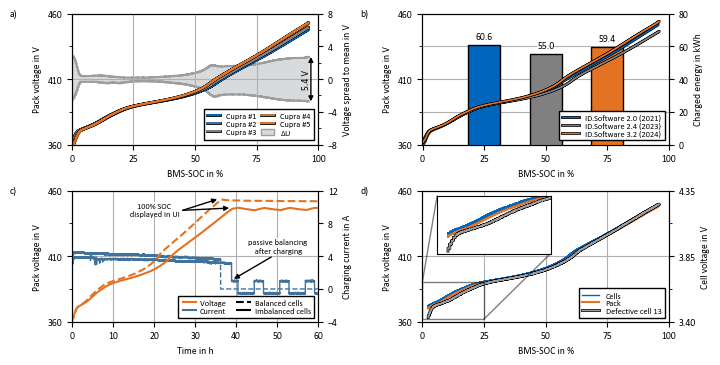

In [144]:
fig = plt.figure(constrained_layout=True,figsize=(cm2inch(VisualizationConfig.textwidth_in_cm.value),
                                                3*cm2inch(3)))
gs= fig.add_gridspec(nrows=2, ncols=2,width_ratios=[1,1])

# gs00 = gs[0].subgridspec(nrows=3, ncols=1,height_ratios=[1,1,1])
# gs01 = gs[1].subgridspec(nrows=2, ncols=2)
#gs03 = gs[2].subgridspec(nrows=1, ncols=1)

# axes1 = fig.add_subplot(gs00[0, 0])
# axes2 = fig.add_subplot(gs00[1, 0])
# axes3 = fig.add_subplot(gs00[2, 0])
# plot_veh2veh(axes1,axes2,axes3)
# axes1 = fig.add_subplot(gs00[0:3, 0])
# plot_veh2veh_one_plot(axes1)

axes1 = fig.add_subplot(gs[0, 0])
plot_model2model(axes1)

axes2 = fig.add_subplot(gs[0, 1])
plot_software(axes2)

axes3 = fig.add_subplot(gs[1, 0])
plot_balance_volt2(axes3)

axes4= fig.add_subplot(gs[1,1])
plot_cell_defect(axes4)
#plt.tight_layout()
axes1.text(-0.25, 1, 'a)', horizontalalignment='left',fontsize=7,
     verticalalignment='center', transform=axes1.transAxes)
axes2.text(-0.25, 1, r'b)', horizontalalignment='left',fontsize=7,
     verticalalignment='center', transform=axes2.transAxes)
axes3.text(-0.25, 1, r'c)', horizontalalignment='left',fontsize=7,
     verticalalignment='center', transform=axes3.transAxes)
axes4.text(-0.25, 1, r'd)', horizontalalignment='left',fontsize=7,
     verticalalignment='center', transform=axes4.transAxes)
# axes6.text(-0.25, 1, r'e)', horizontalalignment='left',fontsize=7,
#      verticalalignment='center', transform=axes6.transAxes)
# axes5.text(-0.25, 1, r'f)', horizontalalignment='left',fontsize=7,
#      verticalalignment='center', transform=axes5.transAxes)
# axes7.text(-0.25, 1, r'g)', horizontalalignment='left',fontsize=7,
#      verticalalignment='center', transform=axes7.transAxes)
#fig.align_labels([axes4,axes6])

fig.savefig(os.path.join(GeneralConfig.path2figures.value,"02-POCV_discussion.pdf"))
fig.savefig(os.path.join(GeneralConfig.path2figures.value,"02-POCV_discussion.png"),dpi=300, pad_inches = 0)

In [67]:
def plot_balance_volt(axes):
    sec_ax = axes.twinx()
    axes.set_zorder(sec_ax.get_zorder()+1)  # default zorder is 0 for ax1 and ax2
    axes.patch.set_visible(False) 
    
    axes.grid()
    axes.set_axisbelow(True)
    axes.plot(df_vw_relax["time_h"]-24.5-12,df_vw_relax["I"].rolling(2).mean()*(40/16)+ 430,color=colors[1],linewidth=1,alpha=1)
    axes.plot(df_vw_balance["time_h"]-12,df_vw_balance["I"].rolling(2).mean()*(40/16) + 430,color=colors[4],linewidth=1,alpha=1,)
    
    axes.plot(df_vw_relax["time_h"]-24.5-12,df_vw_relax["U"],color=colors[1],label="",linestyle="--")
    axes.plot(df_vw_balance["time_h"]-12,df_vw_balance["U"],color=colors[4],alpha=1,label="Balancing",linestyle="--")

    

    axes.set_xlim([-10,25])
    tick_positions = np.array([-10,0,10,20,25])
    axes.set_xticks(tick_positions)
    axes.set_ylim([420,460])
    tick_positions = np.array([420,440,460])
    axes.set_yticks(tick_positions)
    axes.yaxis.set_minor_locator(FixedLocator([430,450]))
    #tick_positions = np.array([360,410,460])
    #axes.set_yticks(tick_positions)
    #axes.yaxis.set_minor_locator(FixedLocator([385,435]))
    axes.set_ylabel("Pack voltage in V")

    # legend
    # handles, labels =axes.get_legend_handles_labels()  
    # line = plt.hlines(-1,0,1,label='Voltage ', color="black")
    # line1 = plt.hlines(-1,0,1,label='Current', color="black",linestyle="--")
    # line2 = plt.hlines(-1,0,1,label='No balancing', color=VisualizationConfig.TUMblau.value)
    # line3 = plt.hlines(-1,0,1,label='Balancing', color=VisualizationConfig.TUMorange.value)
    
    # # add manual symbols to auto legend
    # handles.extend([line,line1, line2,line3])
    # axes.legend(handles=handles,loc="lower right",ncols=2,handletextpad=0.4,fontsize=6,
    #            framealpha =1 , fancybox=False,labelspacing=0.1,columnspacing=1,edgecolor="black",handlelength=1.8)

    axes.legend(loc="lower right", framealpha =1,ncols=1, fancybox=False,labelspacing=0.1,columnspacing=1,edgecolor="black",fontsize=6)
    axes.set_xlabel("Time after full charge in h")
      
    sec_ax.plot(df_vw_relax["time_h"]-24.5-12,df_vw_relax["I"].rolling(2).mean(),color=colors[1],linewidth=1,alpha=0)
    sec_ax.plot(df_vw_balance["time_h"]-12,df_vw_balance["I"].rolling(2).mean(),color=colors[4],linewidth=1,alpha=0)
    sec_ax.set_xlim([-10,25])
    sec_ax.set_ylim([-4,12])
    tick_positions = np.array([-4,0,4,8,12])
    #sec_ax.yaxis.set_minor_locator(FixedLocator([-3,3]))
    sec_ax.set_yticks(tick_positions)
    sec_ax.set_ylabel("Charging current in A")

    return

In [68]:
850-630

220

In [69]:
df_taycan["U"].min()

633.7

Text(0.5, 0, 'Time after full charge in h')

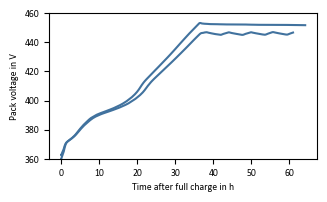

In [70]:
fig, axes= plt.subplots(1,1,
                        figsize=(cm2inch(VisualizationConfig.columnwidth_in_cm.value),
                                cm2inch(4.8)))
# sec_ax = axes.twinx()
# axes.set_zorder(sec_ax.get_zorder()+1)  # default zorder is 0 for ax1 and ax2
# axes.patch.set_visible(False) 

# axes.grid()
# axes.set_axisbelow(True)
# axes.plot(df_vw_relax["time_h"],df_vw_relax["I"].rolling(2).mean()*(40/16)+ 430,color=colors[1],linewidth=1,alpha=1)
# axes.plot(df_vw_balance2["time_h"],df_vw_balance2["I"].rolling(2).mean()*(40/16) + 430,color=colors[4],linewidth=1,alpha=1,)

#axes.plot(df_vw_relax["time_h"],df_vw_relax["U"],color=colors[1],label="")
#.plot(df_vw_balance2["time_h"],df_vw_balance2["U"],color=colors[1],alpha=1,label="Appended balacing")
axes.plot(df_vw_relax["time_h"],df_vw_relax["U"],color=colors[1],label="")
axes.plot(df_vw_balance2["time_h"]*0.94,df_vw_balance2["U"],color=colors[1],alpha=1,label="Appended balacing")


#axes.set_xlim([-10,25])
#tick_positions = np.array([-10,0,10,20,25])
#axes.set_xticks(tick_positions)
axes.set_ylim([360,460])
#tick_positions = np.array([420,440,460])
#axes.set_yticks(tick_positions)
#axes.yaxis.set_minor_locator(FixedLocator([430,450]))
#tick_positions = np.array([360,410,460])
#axes.set_yticks(tick_positions)
#axes.yaxis.set_minor_locator(FixedLocator([385,435]))
axes.set_ylabel("Pack voltage in V")
#axes.legend(loc="lower right", framealpha =1,ncols=1, fancybox=False,labelspacing=0.1,columnspacing=1,edgecolor="black",fontsize=6)
axes.set_xlabel("Time after full charge in h")
  
# sec_ax.plot(df_vw_relax["time_h"]-24.5-12,df_vw_relax["I"].rolling(2).mean(),color=colors[1],linewidth=1,alpha=0)
# sec_ax.plot(df_vw_balance["time_h"]-12,df_vw_balance["I"].rolling(2).mean(),color=colors[4],linewidth=1,alpha=0)
# sec_ax.set_xlim([-10,25])
# sec_ax.set_ylim([-4,12])
# tick_positions = np.array([-4,0,4,8,12])
# #sec_ax.yaxis.set_minor_locator(FixedLocator([-3,3]))
# sec_ax.set_yticks(tick_positions)
# sec_ax.set_ylabel("Charging current in A")

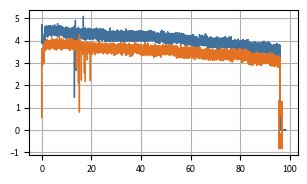

In [71]:
fig, axes= plt.subplots(1,1,
                        figsize=(cm2inch(VisualizationConfig.columnwidth_in_cm.value),
                                cm2inch(4.8)))
axes.grid()
axes.set_axisbelow(True)
axes.plot(df_vw_relax["SOC"],df_vw_relax["I"].rolling(2).mean(),color=colors[1],linewidth=1,alpha=1)
axes.plot(df_vw_balance2["SOC"],df_vw_balance2["I"].rolling(2).mean(),color=colors[4],linewidth=1,alpha=1,)